In [7]:
import time

import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
import random
## keras stuff
import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Input, Activation, \
                    Dropout, Flatten, Conv2D, MaxPooling2D

from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D,Conv2D, MaxPooling2D, ZeroPadding2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.datasets import cifar10
from keras import backend as K
from keras import regularizers
from keras import optimizers
from keras.layers.core import Lambda
import os

os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

Using TensorFlow backend.


## getting CIFAR-10 dataset
    helper functions

In [8]:
def unpickle(file):
    import pickle
    with open(file, 'br') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#returns a uint8 numpy array with m x n x color(R,G,o B)
def from_array_to_RGB(I_lin,channel_size=1024):
    L = channel_size
    side = int(np.sqrt(L)) #square image
    
    I = np.zeros((side,side,3),dtype=np.uint8)
    #==== color channels
    #R
    I[:,:,0] = I_lin[0:L].reshape((side,side)) 
    #G
    I[:,:,1] = I_lin[L:2*L].reshape((side,side))
    #B
    I[:,:,2] = I_lin[2*L:3*L].reshape((side,side))
    return I

## select_random_images_in_batch
#     Selects random images from the loaded batch, and saves them in a list.
#         1st column: image
#         2nd column: label
def select_random_images_in_batch(batch,no_of_samples=5):
    selection = random.sample(range(batch[b'data'].shape[0]), no_of_samples)
    I = []
    
    for i in range(len(selection)):
        index = selection[i]
        I.append( (from_array_to_RGB(batch[b'data'][index], \
                                   batch[b'data'][index].size//3),\
                                   batch[b'labels'][index], index) )
               
    return I

## display 25 random images from CIFAR dataset
    
       this selects 5 random images from each batch_n file, n = 1..5
       
       batches is a Python list that holds dictionaries:
            batches[0][b'data] returns 10,000 horizontalized images.
            batches[0][b'data][0] is the 1st image in the dataset

B:\code\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


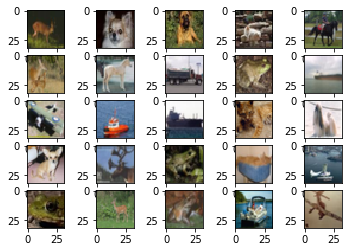

In [9]:
path = os.getcwd() + "\\cifar-10-batches-py\\"
file = []
batches = []

# file = ['data_batch_{}'.format(i) for i in range(5)]
for i in range(5): #getting path + name of the folder for the dataset
    batches.append(unpickle(path + "data_batch_" + str(i+1)))
batches.append(unpickle( path + "test_batch" )) 

m = 5
no_of_samples = m**2
I_list = []
for i in range(m):
    I_list = select_random_images_in_batch(batches[i], no_of_samples)
    for j in range(no_of_samples):
        plt.subplot(m,m,j+1)
        plt.imshow(I_list[j][0])
        plt.show

## preprocessing dataset
    putting all batches together in one variable

In [10]:
num_of_classes = 10

X_train, X_test = [],[]
t_train, t_test = [],[]

k = 0
for i in range(len(batches)):
    for j in range(10_000):
        if i == (len(batches)-1): #test set
            X_test.append(from_array_to_RGB(batches[i][b'data'][j], \
                               batches[i][b'data'][j].size//3))
            t_test.append(batches[i][b'labels'][j])        
        else: #train test
            X_train.append(from_array_to_RGB(batches[i][b'data'][j], \
                               batches[i][b'data'][j].size//3))
            t_train.append(batches[i][b'labels'][j])
#binarize labels for use with VGG16
t_train = keras.utils.np_utils.to_categorical(t_train, num_of_classes)
t_test = keras.utils.np_utils.to_categorical(t_test, num_of_classes)

#normalized by dividing byt the max
X_train = np.asarray(X_train,dtype=np.float32)/255
X_train = X_train.astype('float16')

X_test = np.asarray(X_test,dtype=np.float32)/255
X_test = X_test.astype('float16')

## calculations for stride/filter size and image size match

In [11]:
stride = lambda W,F,P,S: (W-F+2*P)/S + 1 
#1. cond2d layer
print(32)
NEW_W = stride(32,4,0,2)
# print(NEW_W)
#1. maxpooling layer
NEW_W = stride(NEW_W,3,0,1)
print(NEW_W)
#####################
#2. cond2d layer
NEW_W = stride(NEW_W,3,1,1)
# print(NEW_W)
#2. maxpooling layer
NEW_W = stride(NEW_W,3,0,1)
print(NEW_W)
#####################
#3. cond2d layer
NEW_W = stride(NEW_W,3,1,1)
# print(NEW_W)
#3. maxpooling layer
NEW_W = stride(NEW_W,3,0,1)
print(NEW_W)
#####################

32
13.0
11.0
9.0


## parameters for CNN

In [14]:
batch_size = 500
num_classes = 10
X_shape = [32,32,3]

learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20
maxepochs = 50

## (very small) VGG16-inspired CNN

In [19]:
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
def alexsoaresnet(weights_path=None):
    weight_decay = 1e-6
    model = Sequential()
####################
    model.add(keras.layers.ZeroPadding2D(padding=(3, 1)))
    model.add(Conv2D(48, (4, 4), strides=2, padding='valid', \
                     input_shape=(32,32,3),kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
####################
    model.add(keras.layers.ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(192, (3, 3), padding='valid', \
                     input_shape=(13,13,24), kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
####################
    model.add(keras.layers.ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(128, (3, 3), padding='valid', \
                     input_shape=(11,11,96), kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=1))
####################
    model.add(Flatten())
    model.add(Dense(256,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
####################
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    if weights_path:
        model.load_weights(weights_path, by_name=True)
    
    model.compile(loss='categorical_crossentropy',\
                  optimizer=sgd, metrics=['accuracy'])
    
    return model

  ## image settings for running the network

In [20]:
datagen = ImageDataGenerator(    
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).

## compiling and running the network

In [22]:
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop)) 
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

as_net = alexsoaresnet()


# as_net.summary()
# # for i in range(len(VGG_NN.layers)):
# #     VGG_NN.layers[i].trainable = False
# alexSnet = as_net.fit_generator(datagen.flow(X_train, t_train,\
#                                         batch_size=batch_size),\
#                            steps_per_epoch=X_train.shape[0] // batch_size,\
#                            epochs=maxepochs, validation_data=(X_test, t_test),\
#                            callbacks=[reduce_lr], verbose=1)

In [23]:
as_net

In [24]:
as_net.summary()

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 